In [1]:
from cProfile import label
import numpy as np
import matplotlib.pyplot as plt
import nashpy as nash
import itertools
import cvxpy as cp

from compute_solns import *

# Set up game

state_names = ["s1"]
round = 2
risk_levels = np.linspace(0,100,101)
states = []
for name in state_names:
    for risk in risk_levels:
        states.append((name, risk))

human_actions = [1,5,10]
robot_actions = ["S","F"]

gamma = 1
T = 10

# def project_risk(r):
#     r = np.round(r,round)
#     return np.max([l for l in risk_levels if l <= r ])
    # return risk_levels[np.argmin([np.abs(r-l) for l in risk_levels])]

def transition(state, uH, uR, dr, check=False):
    s = state[0]
    if check and state[1] + dr < 0:
        print("RIP: Risking more than you've won")
    # r = risk_levels[np.argmin([np.abs(state[1]+dr-l) for l in risk_levels])]
    r = proj_risk(state[1]+dr, risk_levels)
    return (s,r)
        
def reward(state, uH, uR):
    rR = (2 if uR=="S" else 0)*uH
    rH = (10-uH)
    social = rR + rH
    return (social,social,social)


game = {
    "state_names":state_names, "states":states, "risk_levels":risk_levels,
    "human_actions":human_actions, "robot_actions":robot_actions,
    "transition":transition, "reward":reward,
    "gamma":gamma, "T":T,
    "misc":{"round":round}
}

# Compute solutions
solns = compute_ex_post(game)

# print(solns["adv_val"][0])

# Simulation parameters
s0 = ("s1",proj_risk(3, risk_levels))

seed = None
n_rollouts_max = 30

sim = lambda opp_type: simulate(s0, game, solns, opp_type, seed)
comp_stats = lambda n, opp_type: compute_stats(n, s0, game, solns, opp_type, seed)

# Issues to talk about: projecting onto risk levels when they become negative
# Memoization

Computing baseline...
9, 8, 7, 6, 5, 4, 3, 2, 1, 0, Done with baseline!
Computing maximax...
9, 8, 7, 6, 5, 4, 3, 2, 1, 0, Done with maximax!
Computing ex post solution...
9, Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-11
8, 7, 6, 5, 4, 3, 2, 1, 0, Done with ex post!


In [2]:
comp_stats(1, ("maximax", "adv"))

('maximax', 'adv')
s1
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0
(0, 0, 0)
state= s1 , uH= 10 , strat= [[0. 0. 1.]] , uR= F total_r= 0


{'average_reward': 0.0,
 'std_reward': 0.0,
 'baseline_reward': 90.00000005005532,
 'rewards': [0]}

In [10]:
h_types = ["gift", "maximax", "baseline"]
r_types = ["coop", "adv", "random"]

opp_types = [(h,r) for h in h_types for r in r_types]

for opp in opp_types:
    stats = comp_stats(1,opp)
    print(stats)

('gift', 'coop')
('s1', 3.0)
{'average_reward': 186.0, 'std_reward': 0.0, 'baseline_reward': 90.00000005005532, 'rewards': [186]}
('gift', 'adv')
('s1', 3.0)
{'average_reward': 90.0, 'std_reward': 0.0, 'baseline_reward': 90.00000005005532, 'rewards': [90]}
('gift', 'random')
('s1', 3.0)
{'average_reward': 92.0, 'std_reward': 0.0, 'baseline_reward': 90.00000005005532, 'rewards': [92]}
('maximax', 'coop')
{'average_reward': 200.0, 'std_reward': 0.0, 'baseline_reward': 90.00000005005532, 'rewards': [200]}
('maximax', 'adv')
{'average_reward': 0.0, 'std_reward': 0.0, 'baseline_reward': 90.00000005005532, 'rewards': [0]}
('maximax', 'random')
{'average_reward': 80.0, 'std_reward': 0.0, 'baseline_reward': 90.00000005005532, 'rewards': [80]}
('baseline', 'coop')
{'average_reward': 110.0, 'std_reward': 0.0, 'baseline_reward': 90.00000005005532, 'rewards': [110]}
('baseline', 'adv')
{'average_reward': 90.0, 'std_reward': 0.0, 'baseline_reward': 90.00000005005532, 'rewards': [90]}
('baseline', '

In [15]:
h_types = ["gift", "maximax", "baseline"]
r_types = ["coop", "adv", "random"]

opp_types = [(h,r) for h in h_types for r in r_types]

print("Computing statistics against different agents")
# Compute statistics for different agents
n = 1
res = {opp:[] for opp in opp_types}
for opp in opp_types:
    stats = comp_stats(n,opp)
    delta = (stats["average_reward"], stats["std_reward"])
    res[opp] = delta

# print("Plotting results")
# # Plot statistics
# plt.figure()
# plt.title("Average reward - baseline for n rollouts")
# x_vals = range(1,n_rollouts_max)
# for opp in opp_types:
#     res_opp = res[opp]
#     plt.plot(x_vals, res_opp, label=opp)
# plt.plot(x_vals, [-s0[1] for _ in x_vals], label="Initial risk capital")
# plt.xlabel("Number of rollouts")
# plt.ylabel("Average reward - baseline")
# plt.legend()
# plt.show()

Computing statistics against different agents
('gift', 'coop')
('s1', 3.0)
('gift', 'adv')
('s1', 3.0)
('gift', 'random')
('s1', 3.0)
('maximax', 'coop')
('maximax', 'adv')
('maximax', 'random')
('baseline', 'coop')
('baseline', 'adv')
('baseline', 'random')


<ErrorbarContainer object of 3 artists>

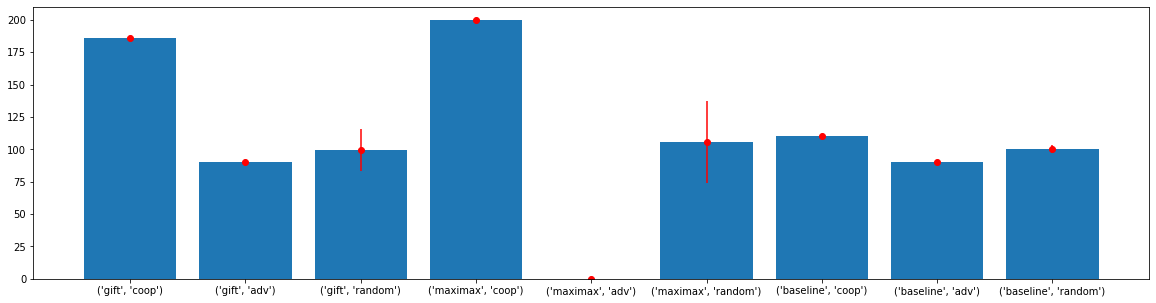

In [12]:
ress = list(zip(*res.items()))
x,z = ress[0],ress[1]
x = [str(i) for i in x]
y = [i[0] for i in z]
c  = [i[1] for i in z]
plt.figure(figsize=(20,5))
plt.bar(x,y)
plt.errorbar(x, y, yerr=c, fmt="o", color="r")

In [16]:
res

{('gift', 'coop'): (186.0, 0.0),
 ('gift', 'adv'): (90.0, 0.0),
 ('gift', 'random'): (98.34, 14.047932232182784),
 ('maximax', 'coop'): (200.0, 0.0),
 ('maximax', 'adv'): (0.0, 0.0),
 ('maximax', 'random'): (100.4, 29.117692216245434),
 ('baseline', 'coop'): (110.0, 0.0),
 ('baseline', 'adv'): (90.0, 0.0),
 ('baseline', 'random'): (99.82, 2.954251174155644)}

In [11]:
s0 = ("s1",proj_risk(4, risk_levels))
sim = lambda opp_type: simulate_old(s0, game, solns, opp_type, seed)
comp_stats = lambda n, opp_type: compute_stats(n, s0, game, solns, opp_type, seed)

opp_types = ["coop", "adv", "random"]

# Simulate against different agents
for opp in opp_types:
    sim(opp)

Testing with coop agent
('s1', 4.0)
state= ('s1', 9.0) , uH= 5 , strat= [[1.67742094e-09 9.99999998e-01 0.00000000e+00]] , uR= S , dr= 5.9999999932903165 , r+dr= 9.999999993290317 , constraint= 6.7096834754920565e-09
state= ('s1', 19.0) , uH= 10 , strat= [[0.00000000e+00 3.59896081e-10 1.00000000e+00]] , uR= S , dr= 10.999999998200522 , r+dr= 19.999999998200522 , constraint= 1.7994779000218841e-09
state= ('s1', 29.0) , uH= 10 , strat= [[0.00000000e+00 2.03196604e-10 1.00000000e+00]] , uR= S , dr= 10.999999998984023 , r+dr= 29.999999998984023 , constraint= 10.000000001015984
state= ('s1', 40.0) , uH= 10 , strat= [[0. 0. 1.]] , uR= S , dr= 11.0 , r+dr= 40.0 , constraint= 20.0
state= ('s1', 51.0) , uH= 10 , strat= [[0. 0. 1.]] , uR= S , dr= 11.0 , r+dr= 51.0 , constraint= 31.0
state= ('s1', 61.0) , uH= 10 , strat= [[1.61360179e-09 1.41181784e-09 9.99999997e-01]] , uR= S , dr= 10.9999999784185 , r+dr= 61.9999999784185 , constraint= 42.000000021581506
state= ('s1', 71.0) , uH= 10 , strat= [

In [14]:
comp_stats(1, "maximax")

Exception: Human type not available, select from gift, maximax, baseline.

In [ ]:
risk_levels

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])